# Data Cleaning


In this notebook, we go thorugh all the columns and fix missing values, get rid of some unwanted columns, and also add new columns with meaningful values. 

## Loading modules

In [1]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [3]:
pd.set_option('display.max_columns', None)

## Loading the data

We already acquired the flight data from the [Bureau of Transportation Statisitcs](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time), and engineered some interesting features about flight's historical performance. The flight data with historical information was then merged with [weather datasets](https://www.wunderground.com/weather/api) at top 20 US airports. Details about the data acquisition and merging can be found in this notebook: /springboard-datascience-intensive/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb.

So, after running that python notebook (data_acquisition_merging.ipynb), we get the following csv file, which we can load for EDA now.   

In [4]:
df = pd.read_csv("../Data/MergedData/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports.csv")

In [5]:
df.shape

(2857139, 150)

In [6]:
df.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,FlightDateAtDest,CRSDepHr,CRSArrHr,Hour_Origin,Minute_Origin,TimeZone_Origin,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindGust_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,WindChill_Origin,HeatIndex_Origin,Precipitation_Origin,Condition_Origin,Fog_Origin,Rain_Origin,Snow_Origin,Hail_Origin,Thunder_Origin,Tornado_Origin,Date_Origin,State_Origin,Airport_Origin,Hour_Dest,Minute_Dest,TimeZone_Dest,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindGust_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,WindChill_Dest,HeatIndex_Dest,Precipitation_Dest,Condition_Dest,Fog_Dest,Rain_Dest,Snow_Dest,Hail_Dest,Thunder_Dest,Tornado_Dest,Date_Dest,State_Dest,Airport_Dest,Year_Dest,Quarter_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest
0,0,2015,1,1,1,4,2015-01-01,AA,19805,AA,N787AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,855.0,-5.0,0.0,0.0,-1.0,0900-0959,17.0,912.0,1230.0,7.0,1230,1237.0,7.0,7.0,0.0,0.0,1200-1259,0.0,NaN,0.0,390.0,402.0,378.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,37,-3.0,180.0,1.0,190.0,24.0,9.0,0.0,0.0,85,-4.0,180.0,-9.0,190.0,22.0,10.0,0.0,0.0,135,-4.0,180.0,-8.0,190.0,22.0,10.0,0.0,0.0,2015-01-01,9,12,9.0,51.0,America/New_York,33.1,5.0,31.0,17.3,NaN,270.0,10.0,30.21,22.2,NaN,NaN,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,NY,JFK,12.0,53.0,America/Los_Angeles,55.0,35.1,47.0,4.6,NaN,0.0,10.0,30.12,NaN,NaN,NaN,Clear,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,CA,LAX,2015,1,1,1,3
1,1,2015,1,1,2,5,2015-01-02,AA,19805,AA,N795AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,850.0,-10.0,0.0,0.0,-1.0,0900-0959,15.0,905.0,1202.0,9.0,1230,1211.0,-19.0,0.0,0.0,-2.0,1200-1259,0.0,NaN,0.0,390.0,381.0,357.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,37,-3.0,180.0,4.0,190.0,23.0,9.0,0.0,0.0,84,-4.0,180.0,-6.5,190.0,22.0,9.0,0.0,0.0,134,-4.0,180.0,-8.5,190.0,22.0,10.0,0.0,0.0,2015-01-02,9,12,9.0,51.0,America/New_York,41.0,18.0,40.0,20.7,NaN,260.0,10.0,30.24,31.6,NaN,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02,NY,JFK,12.0,53.0,America/Los_Angeles,55.0,42.1,62.0,6.9,NaN,260.0,10.0,30.09,NaN,NaN,NaN,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02,CA,LAX,2015,1,1,2,4
2,2,2015,1,1,3,6,2015-01-03,AA,19805,AA,N788AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,853.0,-7.0,0.0,0.0,-1.0,0900-0959,15.0,908.0,1138.0,13.0,1230,1151.0,-39.0,0.0,0.0,-2.0,1200-1259,0.0,NaN,0.0,390.0,358.0,330.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,38,-3.5,180.0,5.5,190.0,23.0,9.0,0.0,0.0,84,-4.0,180.0,-5.0,190.0,22.0,9.0,0.0,0.0,134,-4.0,180.0,-9.5,190.0,22.0

In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,FlightDateAtDest,CRSDepHr,CRSArrHr,Hour_Origin,Minute_Origin,TimeZone_Origin,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindGust_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,WindChill_Origin,HeatIndex_Origin,Precipitation_Origin,Condition_Origin,Fog_Origin,Rain_Origin,Snow_Origin,Hail_Origin,Thunder_Origin,Tornado_Origin,Date_Origin,State_Origin,Airport_Origin,Hour_Dest,Minute_Dest,TimeZone_Dest,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindGust_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,WindChill_Dest,HeatIndex_Dest,Precipitation_Dest,Condition_Dest,Fog_Dest,Rain_Dest,Snow_Dest,Hail_Dest,Thunder_Dest,Tornado_Dest,Date_Dest,State_Dest,Airport_Dest,Year_Dest,Quarter_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest
0,2015,1,1,1,4,2015-01-01,AA,19805,AA,N787AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,855.0,-5.0,0.0,0.0,-1.0,0900-0959,17.0,912.0,1230.0,7.0,1230,1237.0,7.0,7.0,0.0,0.0,1200-1259,0.0,NaN,0.0,390.0,402.0,378.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,37,-3.0,180.0,1.0,190.0,24.0,9.0,0.0,0.0,85,-4.0,180.0,-9.0,190.0,22.0,10.0,0.0,0.0,135,-4.0,180.0,-8.0,190.0,22.0,10.0,0.0,0.0,2015-01-01,9,12,9.0,51.0,America/New_York,33.1,5.0,31.0,17.3,NaN,270.0,10.0,30.21,22.2,NaN,NaN,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,NY,JFK,12.0,53.0,America/Los_Angeles,55.0,35.1,47.0,4.6,NaN,0.0,10.0,30.12,NaN,NaN,NaN,Clear,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,CA,LAX,2015,1,1,1,3
1,2015,1,1,2,5,2015-01-02,AA,19805,AA,N795AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,850.0,-10.0,0.0,0.0,-1.0,0900-0959,15.0,905.0,1202.0,9.0,1230,1211.0,-19.0,0.0,0.0,-2.0,1200-1259,0.0,NaN,0.0,390.0,381.0,357.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,37,-3.0,180.0,4.0,190.0,23.0,9.0,0.0,0.0,84,-4.0,180.0,-6.5,190.0,22.0,9.0,0.0,0.0,134,-4.0,180.0,-8.5,190.0,22.0,10.0,0.0,0.0,2015-01-02,9,12,9.0,51.0,America/New_York,41.0,18.0,40.0,20.7,NaN,260.0,10.0,30.24,31.6,NaN,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02,NY,JFK,12.0,53.0,America/Los_Angeles,55.0,42.1,62.0,6.9,NaN,260.0,10.0,30.09,NaN,NaN,NaN,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02,CA,LAX,2015,1,1,2,4
2,2015,1,1,3,6,2015-01-03,AA,19805,AA,N788AA,1,12478,1247802,31703,JFK,"New York, NY",NY,36,New York,22,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,900,853.0,-7.0,0.0,0.0,-1.0,0900-0959,15.0,908.0,1138.0,13.0,1230,1151.0,-39.0,0.0,0.0,-2.0,1200-1259,0.0,NaN,0.0,390.0,358.0,330.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,38,-3.5,180.0,5.5,190.0,23.0,9.0,0.0,0.0,84,-4.0,180.0,-5.0,190.0,22.0,9.0,0.0,0.0,134,-4.0,180.0,-9.5,190.0,22.0,10.0,0.0,0.0,201

In [9]:
df.shape

(2857139, 149)

There were close to 2.8  million flights in 2015-2016 operating to-and-from the following selected 20 airports.

In [10]:
df[["Origin", "OriginCityName"]].drop_duplicates().sort_values("Origin").set_index("Origin")

,OriginCityName
Origin,
ATL,"Atlanta, GA"
BOS,"Boston, MA"
BWI,"Baltimore, MD"
CLT,"Charlotte, NC"
DEN,"Denver, CO"
DFW,"Dallas/Fort Worth, TX"
DTW,"Detroit, MI"
EWR,"Newark, NJ"
IAH,"Houston, TX"


The justification for selecting these 20 airports is discussed in detail in data_acquisition_merging.ipynb notebook. In nutshell, we could get the weather data for only few airports due to weather API limitations. So, we selected top 20 airports that observe highest landings ans takeoffs in the US.

Discussing the data frame further, we have 149 columns. Let us first calculate the fraction of nulls (or missing values) in each column.

In [11]:
frac_nulls = {col: (sum(df[col].isnull())/len(df)) for col in df.columns}
frac_nulls = sorted(frac_nulls.items(), key = operator.itemgetter(1))
frac_nulls

[('Year', 0.0),
 ('Quarter', 0.0),
 ('Month', 0.0),
 ('DayofMonth', 0.0),
 ('DayOfWeek', 0.0),
 ('FlightDate', 0.0),
 ('UniqueCarrier', 0.0),
 ('AirlineID', 0.0),
 ('Carrier', 0.0),
 ('FlightNum', 0.0),
 ('OriginAirportID', 0.0),
 ('OriginAirportSeqID', 0.0),
 ('OriginCityMarketID', 0.0),
 ('Origin', 0.0),
 ('OriginCityName', 0.0),
 ('OriginState', 0.0),
 ('OriginStateFips', 0.0),
 ('OriginStateName', 0.0),
 ('OriginWac', 0.0),
 ('DestAirportID', 0.0),
 ('DestAirportSeqID', 0.0),
 ('DestCityMarketID', 0.0),
 ('Dest', 0.0),
 ('DestCityName', 0.0),
 ('DestState', 0.0),
 ('DestStateFips', 0.0),
 ('DestStateName', 0.0),
 ('DestWac', 0.0),
 ('CRSDepTime', 0.0),
 ('DepTimeBlk', 0.0),
 ('CRSArrTime', 0.0),
 ('ArrTimeBlk', 0.0),
 ('Cancelled', 0.0),
 ('Diverted', 0.0),
 ('Flights', 0.0),
 ('Distance', 0.0),
 ('DistanceGroup', 0.0),
 ('DivAirportLandings', 0.0),
 ('Nflights_10', 0.0),
 ('Nflights_20', 0.0),
 ('Nflights_30', 0.0),
 ('FlightDateAtDest', 0.0),
 ('CRSDepHr', 0.0),
 ('CRSArrHr', 0.0

Details about each column can be found [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=236) and [here](https://www.wunderground.com/weather/api/d/docs?d=resources/phrase-glossary) and some in /springboard-datascience-intensive/capstone_project/DataAcquisitionMerging/history_calc.ipynb. The column ***<font color='green' size=3>"Cancelled"</font>*** has no missing value which is great. ***<font color='green' size=3>Note that the text used in green is used throughout this notebook to indicate that this variable can be a good candidate for the machine learning model</font>***. The "Cancelled" column has two values: 1 for canceled flights and 0 for not-canceled flights. What is the fraction of those 1.4+ million flights (at 20 airports) that got canceled in the year 2015? 

In [12]:
print(100*sum(df.Cancelled == 1)/len(df), "% of the total flights were cancelled in the years 2015-2016 at top 20 airports in the US.")

1.1486665507 % of the total flights were cancelled in the years 2015-2016 at top 20 airports in the US.


This does not seem like a large number but such rare events cause a lot of troubles to passengers, and cost lot of money to airline industries. So, it is very important to predict the likelihood of even such rare events. Let us visualize the total number of flight cancellations on a daily basis.

In [13]:
df["FlightDate"] = pd.to_datetime(df["FlightDate"])

In [14]:
def hide_topright(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

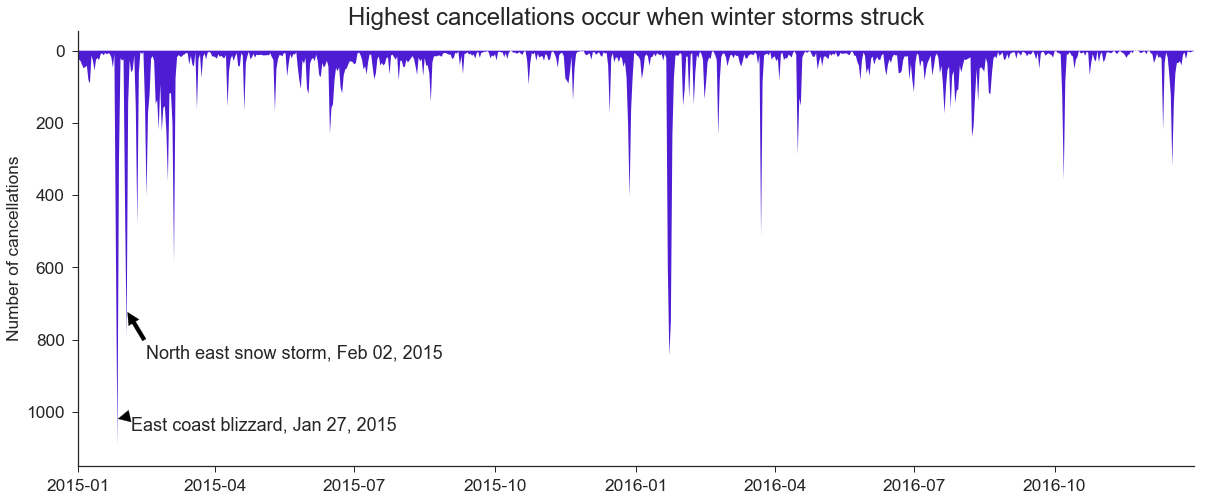

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
d = df.groupby(["FlightDate"])["Cancelled"].sum()
ax.fill_between(d.index, d.values, np.min(d.values), 
                facecolor=(78/255.0, 29/255.0, 211/255.0), linewidth =0.5)
ax.annotate('East coast blizzard, Jan 27, 2015', xy=('2015-01-27', 1020), xytext=('2015-02-05', 1050), size=18,
           arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('North east snow storm, Feb 02, 2015', xy=('2015-02-02', 720), xytext=('2015-02-15', 850), size=18,
           arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title("Highest cancellations occur when winter storms struck", size=24)
hide_topright(ax)
plt.gca().invert_yaxis()
plt.xlim(('2015-01-01', '2016-12-31'))
plt.ylabel("Number of cancellations")

Flight cancellations are mainly caused by bad weather as depicted above. For example, two major snow storms in January-Feberuary 2015 in east coase and north east led to cancelling thousands of flights. Here we do not have such big number as the data contains only 20 airports. However, we do see a trend. A similar spike is seen in January-February 2016 too. There are some cancellation activities in the middle of June-July too. Otherwise, except end of January to middle of March, and also end of December, the cancellation rates are quite low.

Before proceeding further to explore the relationships between cancellation rate and all other variables, let us first understand and then fix and/or remove (if needed) columns with missing values. This would help us in figuring out which columns to keep or not in our analysis and modeling. As we saw above the frac_nulls array, there are some columns that do not have any missing values and there are some that contains different fractions of null values. Lets first go through the columns that have missing values. After fixing/removing such columns, we will then focus on all the columns that do not have any missing values. 


### Addressing columns with missing values

#### CRSElapsedTime: 
This is the flight elapsed time generated from the computerized reservation system (CRS). This elapsed time also includes the time-zone difference. When do we get null values for this column?

In [16]:
df[pd.isnull(df.CRSElapsedTime)] 

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,FlightDateAtDest,CRSDepHr,CRSArrHr,Hour_Origin,Minute_Origin,TimeZone_Origin,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindGust_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,WindChill_Origin,HeatIndex_Origin,Precipitation_Origin,Condition_Origin,Fog_Origin,Rain_Origin,Snow_Origin,Hail_Origin,Thunder_Origin,Tornado_Origin,Date_Origin,State_Origin,Airport_Origin,Hour_Dest,Minute_Dest,TimeZone_Dest,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindGust_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,WindChill_Dest,HeatIndex_Dest,Precipitation_Dest,Condition_Dest,Fog_Dest,Rain_Dest,Snow_Dest,Hail_Dest,Thunder_Dest,Tornado_Dest,Date_Dest,State_Dest,Airport_Dest,Year_Dest,Quarter_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest
333015,2015,2,4,26,7,2015-04-26,NK,20416,NK,N614NK,720,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,2059,2057.0,-2.0,0.0,0.0,-1.0,2000-2059,13.0,2110.0,NaN,NaN,2350,NaN,NaN,NaN,NaN,NaN,2300-2359,1.0,B,0.0,NaN,NaN,NaN,1.0,641.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,10,-1.0,186.0,10.5,178.0,12.5,9.5,0.0,0.0,20,0.5,186.0,8.0,178.0,11.0,7.0,0.0,0.0,30,-1.5,186.0,1.5,178.0,12.0,7.0,0.0,0.0,2015-04-26,20,23,20.0,53.0,America/Denver,41.0,41.0,100.0,11.5,NaN,80.0,2.0,30.00,34.3,NaN,0.02,Light Rain,0.0,1.0,0.0,0.0,0.0,0.0,2015-04-26,CO,DEN,23.0,53.0,America/Chicago,72.0,64.9,78.0,10.4,NaN,60.0,10.0,29.65,NaN,NaN,0.02,Light Thunderstorms and Rain,0.0,1.0,0.0,0.0,1.0,0.0,2015-04-26,TX,DFW,2015,2,4,26,6
492714,2015,2,5,10,7,2015-05-10,NK,20416,NK,N534NK,368,13930,1393003,30977,ORD,"Chicago, IL",IL,17,Illinois,41,10821,1082103,30852,BWI,"Baltimore, MD",MD,24,Maryland,35,825,1214.0,229.0,229.0,1.0,12.0,0800-0859,18.0,1232.0,NaN,NaN,1118,NaN,NaN,NaN,NaN,NaN,1100-1159,1.0,C,0.0,NaN,NaN,NaN,1.0,622.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,10,10.0,60.0,4.0,61.0,13.0,6.0,1.0,0.0,20,-2.0,60.0,-9.0,61.0,12.0,6.0,1.0,0.0,24,-2.0,178.0,-9.0,173.0,12.0,6.0,1.0,0.0,2015-05-10,8,11,8.0,57.0,America/Chicago,46.9,46.0,97.0,9.2,NaN,50.0,0.5,30.03,NaN,NaN,0.00,Light Drizzle,1.0,0.0,0.0,0.0,0.0,0.0,2015-05-10,IL,ORD,11.0,54.0,America/New_York,78.1,64.0,62.0,6.9,NaN,200.0,10.0,30.20,NaN,NaN,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-05-10,MD,BWI,2015,2,5,10,6
1723576,2016,1,3,24,4,2016-03-24,NK,20416,NK,N604NK,219,13930,1393004,30977,ORD,"Chicago, IL",IL,17,Illinois,41,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1215,1210.0,-5.0,0.0,0.0,-1.0,1200-1259,14.0,1224.0,NaN,NaN,1511,NaN,NaN,NaN,NaN,NaN,1500-1559,1.0,A,0.0,NaN,NaN,NaN,1.0,606.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,10,-4.0,53.0,4.0,38.0,18.0,8.0,1.0,0.0,20,-2.0,62.0,-3.0,55.0,15.0,8.0,1.0,0.0,30,-1.5,76.0,4.5,68.0,15.0,8.0,2.0,0.0,2016-03-24,12,15,12.0,51.0,America/Chicago,36.

There are only three flights and that too of Spirit Airlines (NK) for which we see missing values for CRSElapsedTime. Note the airline name using the Carrier code (like NK) can be found [here](http://www.iata.org/publications/Pages/code-search.aspx). Interestingly, all three flights were cancelled. Does this mean that whenever the Spirit Airlines bookings do not tell the CRSElapsedTime, their flights get canceled? This could be a possibility but due to only three instances we should not give much weightage to this observation. In fact, there are 2115 NK flights that got cancelled but the CRSElapsedTime was not missing. 

In [17]:
len(df[["Carrier", "Cancelled", "CRSElapsedTime"]][(df.Carrier == "NK") & (df.Cancelled == 1) & (pd.notnull(df.CRSElapsedTime))])

2115

We can ignore this observation about CRSElapsedTime missing values, and think if we can avoid using this column. The CRSElapsedTime can be highly correlated with "Distance", which does not have any missing values. The higher the flight distance, the higher the CRSElapsedTime will be. If we do have such correlation, then we can 

(i) keep the "Distance" 

(ii) remove the "CRSElapsedTime" column

But before doing that, can we confirm if we do have such a correlation?  

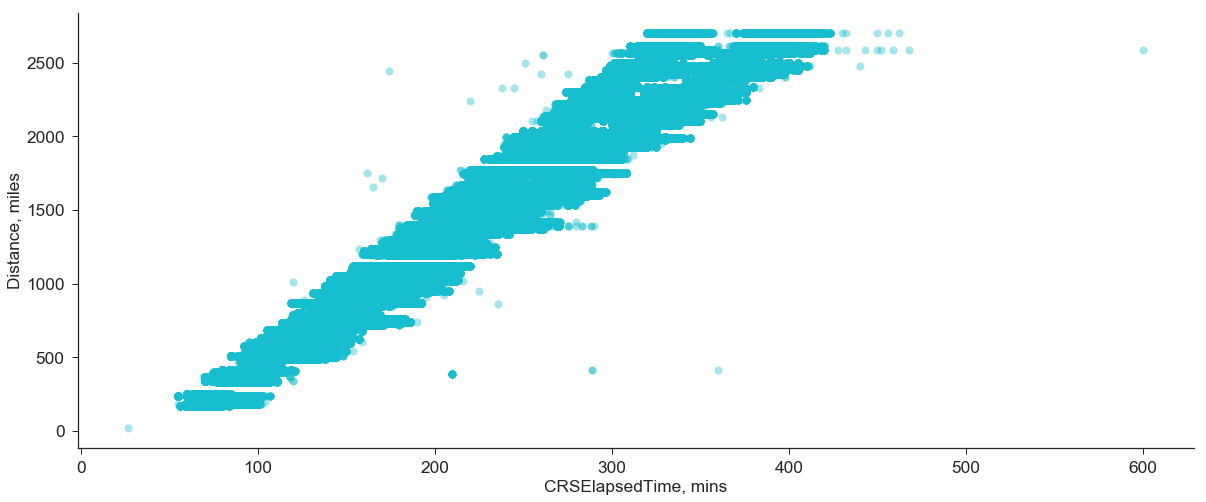

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(df.CRSElapsedTime, df.Distance, marker='o', linestyle='', ms=8, alpha=0.4, 
        c=tableau20[18])
plt.xlabel("CRSElapsedTime, mins")
plt.ylabel("Distance, miles")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Visually, we do observe a positive correlation with few outliers. There are some distances for which there are many CRSElapsedTime. This could be due to time-zone difference, or due to changes in reservation system for same distance flights. Let us quickly perform a hypothesis test to see if there is any correlation. We can calculate a Pearson correlation coefficient. However, this calculation requires that both CRSElapsedTime and Distance are normally distributed. So, let us see their distribution first.

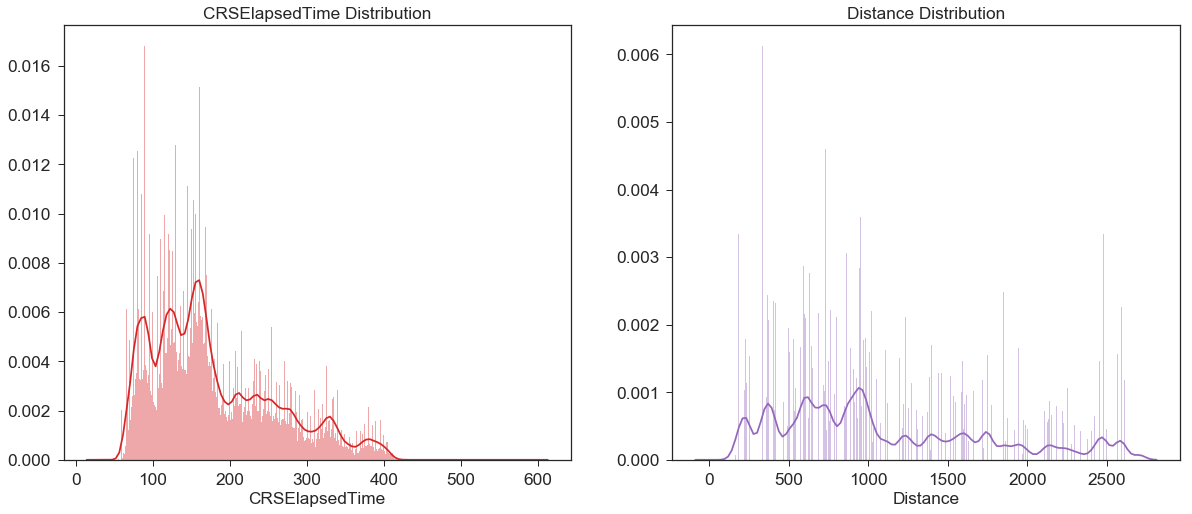

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.distplot(df.CRSElapsedTime[pd.notnull(df.CRSElapsedTime)], 500, ax=ax1, color=tableau20[6])
ax1.set_title("CRSElapsedTime Distribution")
sns.distplot(df.Distance, 500, ax=ax2, color=tableau20[8])
ax2.set_title("Distance Distribution")
plt.show()

These do not look normal distribution. Lets test them:

In [20]:
from scipy import stats

In [21]:
stats.normaltest(df.CRSElapsedTime[pd.notnull(df.CRSElapsedTime)])

NormaltestResult(statistic=247794.95209832463, pvalue=0.0)

In [22]:
stats.normaltest(df.Distance)

NormaltestResult(statistic=243272.27989154751, pvalue=0.0)

Clearly, they are not normally distributed. So, we cannot use the Peasrson's correlation coefficient. We could rather use a non-parametric test such as Spearman's test. Lets calculate the Spearman's correlation coefficient and associated p-value.

In [23]:
stats.spearmanr(df.CRSElapsedTime[pd.notnull(df.CRSElapsedTime)], df.Distance[pd.notnull(df.CRSElapsedTime)])

SpearmanrResult(correlation=0.98156295492992474, pvalue=0.0)

We can reject the null that there is no correlation, and accept the alternate hypothesis that ***there is indeed very strong position correlation (0.98) between the two variables***. Hence, we can drop <font color='red' size=4>CRSElapsedTime</font> from our data set. Note that <font color='red'> the variables in red text in this notebook will indicate that we are removing that variable from the data</font>.

In [24]:
df.drop(["CRSElapsedTime"], axis=1, inplace=True)

In [25]:
df.shape

(2857139, 148)

#### Ncan_30:

This is the number of cancellations in the last 30 days for a given "unique" flight. A unique flight is specified by unique pair of origin-destination and a unique CRSDepTime (scheduled departure time) window. For detailed definition and information, see /springboard-datascience-intensive/capstone_project/DataAcquisitionMerging/history_calc.ipynb.

In [26]:
sum(pd.isnull(df.Ncan_30))

1532

There are 1532 flights for which no 30 days history was found. These flights can be thought of as "temporary" flights (or not routine flights), which airlines industry might run on special ocassions or due to some emergency or to satisfy customer requirements. How many times such "temporary" flights got cancelled? 

In [27]:
sum((pd.isnull(df.Ncan_30)) & (df.Cancelled == 1))

23

About 1.5% of those temporary flights got cancelled. We deal with the missing value by simply substituting 0 in place of missing values because there were no cancellations in last 30 days (as there were no flights). To preserve the information about missing data or "temporary" flight, we create a new indicator column "TempFlight_30" which will have 0 for routine flights and 1 for temporary flights based on 30 days history.

In [28]:
df["TempFlight_30"] = pd.isnull(df.Ncan_30).astype(int)
df.Ncan_30.fillna(0, inplace=True)

#### Ndiv_30:

This is the number of diversions in the last 30 days for a given unique flight. The number of missing rows for this column is exactly same as that for Ncan_30.

In [29]:
sum(pd.isnull(df.Ndiv_30))

1532

Therefore, we perform the same step as we did for Ncan_30, except this time we do not create any indicator column because those 1532 "temporary" flights are the same ones. 

In [30]:
df.Ndiv_30.fillna(0, inplace=True)
# Checking if flights corresponding to missing rows in Ncan_30 and Ndiv_30 are indeed the same ones
df[pd.isnull(df.Ncan_30)].equals(df[pd.isnull(df.Ndiv_30)])

True

#### Ncan_20, Ndiv_20:

Ncan_20 is the number of cancellations amd Ndiv_20 is the number of diversions in the last 20 days for a given unique flight. These columns are similar to Ncan_30 and Ndiv_20, except we are looking at 20 days history rather than 30 days history.

In [31]:
sum(pd.isnull(df.Ncan_20))

1749

In [32]:
sum(pd.isnull(df.Ndiv_20))

1749

There are 1749 missing values or temporary flights based on 20 days history window. Are these flights exactly same for both Ncan_20 and Ndiv_20 columns?

In [33]:
# Checking if flights corresponding to missing rows in Ncan_20 and Ndiv_20 are indeed the same ones
df[pd.isnull(df.Ncan_20)].equals(df[pd.isnull(df.Ndiv_20)])

True

We can apply the same cleaning steps here too, and also create a similar indicator column "TempFlight_20" as what we did for 30 days history columns.

In [34]:
df["TempFlight_20"] = pd.isnull(df.Ncan_20).astype(int)
df.Ncan_20.fillna(0, inplace=True)
df.Ndiv_20.fillna(0, inplace=True)

#### Ncan_10, Ndiv_10:

Ncan_10 is the number of cancellations amd Ndiv_10 is the number of diversions in the last 10 days for a given unique flight.

In [35]:
sum(pd.isnull(df.Ncan_10))

2150

In [36]:
sum(pd.isnull(df.Ndiv_10))

2150

There are 2150 missing values or temporary flights based on 10 days history window. Are these flights exactly same for both Ncan_10 and Ndiv_10 columns?

In [37]:
# Checking if flights corresponding to missing rows in Ncan_10 and Ndiv_10 are indeed the same ones
df[pd.isnull(df.Ncan_10)].equals(df[pd.isnull(df.Ndiv_10)])

True

We can apply the same cleaning steps here too, and also create a similar indicator column "TempFlight_10" as what we did for 30 and 20 days history columns.

In [38]:
df["TempFlight_10"] = pd.isnull(df.Ncan_10).astype(int)
df.Ncan_10.fillna(0, inplace=True)
df.Ndiv_10.fillna(0, inplace=True)

#### Hour_Origin, Minute_Origin, TimeZone_Origin, WindDirection_Origin, Condition_Origin, Fog_Origin, Rain_Origin, Snow_Origin, Hail_Origin, Thunder_Origin, Tornado_Origin, Date_Origin, State_Origin, Airport_Origin

These 14 columns are specific to the origin airports. Most of them are weather factors with some indicating data and time related information. These columns have exactly same value of null fraction (0.0014199519169350878), so most probably the rows (or flights) with missing values are same for all these 14 columns. Can we check this?

In [39]:
# Checking if flights corresponding to missing rows in all these 14 columns are the same ones
print(df[pd.isnull(df.Hour_Origin)].equals(df[pd.isnull(df.Minute_Origin)]))
print(df[pd.isnull(df.Minute_Origin)].equals(df[pd.isnull(df.TimeZone_Origin)]))
print(df[pd.isnull(df.TimeZone_Origin)].equals(df[pd.isnull(df.WindDirection_Origin)]))
print(df[pd.isnull(df.WindDirection_Origin)].equals(df[pd.isnull(df.Condition_Origin)]))
print(df[pd.isnull(df.Condition_Origin)].equals(df[pd.isnull(df.Fog_Origin)]))
print(df[pd.isnull(df.Fog_Origin)].equals(df[pd.isnull(df.Rain_Origin)]))
print(df[pd.isnull(df.Rain_Origin)].equals(df[pd.isnull(df.Snow_Origin)]))
print(df[pd.isnull(df.Snow_Origin)].equals(df[pd.isnull(df.Hail_Origin)]))
print(df[pd.isnull(df.Hail_Origin)].equals(df[pd.isnull(df.Thunder_Origin)]))
print(df[pd.isnull(df.Thunder_Origin)].equals(df[pd.isnull(df.Tornado_Origin)]))
print(df[pd.isnull(df.Tornado_Origin)].equals(df[pd.isnull(df.Date_Origin)]))
print(df[pd.isnull(df.Date_Origin)].equals(df[pd.isnull(df.State_Origin)]))
print(df[pd.isnull(df.State_Origin)].equals(df[pd.isnull(df.Airport_Origin)]))

True
True
True
True
True
True
True
True
True
True
True
True
True


In [40]:
sum(pd.isnull(df.Condition_Origin))

4057

There are 4057 missing values in these columns, and they belong to same flights. Now let us think about the columns that can be easily removed. 

In [41]:
df[['Hour_Origin', 'Minute_Origin', 'TimeZone_Origin', 'WindDirection_Origin', 'Condition_Origin', 
    'Fog_Origin', 'Rain_Origin', 'Snow_Origin', 'Hail_Origin', 'Thunder_Origin', 'Tornado_Origin', 
    'Date_Origin', 'State_Origin', 'Airport_Origin']].head(20)

,Hour_Origin,Minute_Origin,TimeZone_Origin,WindDirection_Origin,Condition_Origin,Fog_Origin,Rain_Origin,Snow_Origin,Hail_Origin,Thunder_Origin,Tornado_Origin,Date_Origin,State_Origin,Airport_Origin
0,9.0,51.0,America/New_York,270.0,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01,NY,JFK
1,9.0,51.0,America/New_York,260.0,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02,NY,JFK
2,9.0,51.0,America/New_York,70.0,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-03,NY,JFK
3,9.0,51.0,America/New_York,200.0,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-04,NY,JFK
4,9.0,51.0,America/New_York,270.0,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-05,NY,JFK
5,9.0,51.0,America/New_York,0.0,Light Snow,0.0,0.0,1.0,0.0,0.0,0.0,2015-01-06,NY,JFK
6,9.0,51.0,America/New_York,280.0,Scattered Clouds,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-07,NY,JFK
7,9.0,51.0,America/New_York,270.0,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-08,NY,JFK
8,9.0,51.0,America/New_York,250.0,Light Snow,0.0,0.0,1.0,0.0,0.0,0.0,2015-01-09,NY,JFK
9,9.0,51.0,America/New_York,290.0,Partly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-10,NY,JFK


We know the CRSDepTime (which has no missing values) so we can extract the hour and minute information from that. Hence, we can remove <font color='red' size=4>Hour_Origin and Minute_Origin</font>. We know the origin airport "Origin" (which has no missing values), so we can drop <font color='red' size=4>TimeZone_Origin, State_Origin and Airport_Origin</font> too. The "Date_Origin" column which is the date at origin airport is exactly same as "FlightDate" (which has no missing values), so we can drop <font color='red' size=4>Date_Origin</font> as well. Lets now discuss the weather factors. There are 6 indicator columns indicating different weather conditions. There is also a "Condition_Origin" column that has much detailed iformation about the weather condition.

In [42]:
print(set(df.Condition_Origin))

{nan, 'Heavy Thunderstorms and Rain', 'Drizzle', 'Thunderstorms with Small Hail', 'Overcast', 'Rain', 'Clear', 'Snow', 'Light Thunderstorms and Rain', 'Squalls', 'Light Snow', 'Ice Pellets', 'Light Rain', 'Fog', 'Heavy Rain', 'Shallow Fog', 'Smoke', 'Light Rain Showers', 'Light Thunderstorms with Small Hail', 'Patches of Fog', 'Light Thunderstorms and Snow', 'Thunderstorm', 'Light Hail', 'Haze', 'Light Ice Pellets', 'Mostly Cloudy', 'Partly Cloudy', 'Blowing Snow', 'Mist', 'Heavy Snow', 'Light Freezing Drizzle', 'Light Drizzle', 'Small Hail', 'Scattered Clouds', 'Thunderstorms and Rain', 'Widespread Dust', 'Unknown', 'Light Freezing Fog', 'Light Freezing Rain', 'Freezing Rain'}


Those 6 indicator columns do not tell the whole story. According to Rain_Origin, there is no difference between "Rain" and "Light Rain". However, the "Condition_Origin" captures the weather condition in much more detail. Therefore, we can drop <font color='red' size=4> Fog_Origin, Rain_Origin, Snow_Origin, Hail_Origin, Thunder_Origin, and Tornado_Origin</font>. We will keep "Condition_Origin".

In [43]:
df.drop(["Hour_Origin", "Minute_Origin", "TimeZone_Origin", "State_Origin", "Airport_Origin",
        "Date_Origin", "Fog_Origin", "Rain_Origin", "Snow_Origin", "Hail_Origin", 
         "Thunder_Origin", "Tornado_Origin"], axis=1, inplace=True)

In [44]:
df.shape

(2857139, 139)

In [54]:
# There are some "Unknown" values in Condition_Origin. Lets replace them by NaN.
df.Condition_Origin[df.Condition_Origin == "Unknown"] = np.nan

In [55]:
sum(pd.isnull(df.Condition_Origin))

4496

Out of 14, only  "WindDirection_Origin" and "Condition_Origin" are left to be fixed. WindDirection_Origin is the direction in degress (0 for north, 90 for east, 180 for south, 270 for west, and various values among these 4 primary directions) at the origin airport. If the wind direction value and Condition_Origin value are missing for a particular flight at a particular departure date and time, we can approximate them with another flight's wind direction value and Condition_Origin value, respectively, which is scheduled to depart just before the hour that the current flight (with missing value) is scheduled to depart. 

Lets create a new column "FlightDateTime", which is just an extension of "Flightdate" with CRSDepTime added. This will help us in finding flights that are scheduled to depart around the same time as the flight that has missing wind direction value. Once we create this new column, we can delete "FlightDate".

In [47]:
%%time
new_col = []
for row in np.arange(len(df)):
    thisDate = df.FlightDate[row]
    # get CRS departure time of current flight
    thisCRSDep = df.CRSDepTime[row]
    thisCRSDepFormatted = datetime.datetime.strptime(str(thisCRSDep).zfill(4), "%H%M")
    # get hour of the current flight
    thisHour = thisCRSDepFormatted.hour
    # get minute of the current flight
    thisMin = thisCRSDepFormatted.minute
    # gupdate the current flight's date with hour and minute
    new_col.append(thisDate + pd.DateOffset(hour = thisHour, minute = thisMin))

CPU times: user 4min 35s, sys: 966 ms, total: 4min 36s
Wall time: 4min 37s


In [56]:
df["FlightDateTime"] = new_col

In [58]:
# dropping original FlightDate
df.drop(["FlightDate"], axis=1, inplace=True)

In [59]:
# Sorting the data frame based on FlightDateTime
df = df.sort_values("FlightDateTime")

In [60]:
df = df.reset_index()
df = df.drop("index", axis=1)

Lets now createa function that would fill the missing value in any given column, where we want to fill the missing values by the data available at earlier hour. 

In [63]:
def fill_missing_value_using_earlier_time(col, df, loc):
    # col: the column we want to fix
    # df: the original data frame
    # loc: location - either "Origin" or "Dest", depending on which loc we are interested in fixing the weather columns for
    for org in set(df[loc]):
        # filtering based on origin airport
        dft = df[df[loc] == org]
        # filling missing values for chosen airport
        dft[col] = dft[col].fillna(method='ffill')
        # replacing the column in the original data frame with the column with no missing values
        df.loc[dft.index, col] = dft[col]
    return(df)

In [64]:
df = fill_missing_value_using_earlier_time("WindDirection_Origin", df, "Origin")

In [65]:
sum(pd.isnull(df.WindDirection_Origin))

0

In [66]:
df = fill_missing_value_using_earlier_time("Condition_Origin", df, "Origin")

In [67]:
sum(pd.isnull(df.Condition_Origin))

0

Ok, so we have taken care of the missing values in the wind direction at origin airport. Lets now move on to the next items in the "frac_nulls" array.


#### Pressure_Origin, DewPoint_Origin, Temperature_Origin, Humidity_Origin, Visibility_Origin, WindSpeed_Origin


These 6 columns are also about the weather factors at origin airports. They have different number of missing values in them (0.149% to 0.179%). We can fix the missing values in these columns in a similar manner as we did for "WindDirection_Origin" because we ***assume*** that these weather factors are going to remain almost same within an hour or two. So, we can make those approximations and fill in the the missing values.

In [68]:
df = fill_missing_value_using_earlier_time("Pressure_Origin", df, "Origin")

In [69]:
df = fill_missing_value_using_earlier_time("DewPoint_Origin", df, "Origin")

In [70]:
df = fill_missing_value_using_earlier_time("Temperature_Origin", df, "Origin")

In [71]:
df = fill_missing_value_using_earlier_time("Humidity_Origin", df, "Origin")

In [72]:
df = fill_missing_value_using_earlier_time("Visibility_Origin", df, "Origin")

In [73]:
df = fill_missing_value_using_earlier_time("WindSpeed_Origin", df, "Origin")

#### Hour_Dest, Minute_Dest, TimeZone_Dest, WindDirection_Dest, Condition_Dest, Fog_Dest, Rain_Dest, Snow_Dest, Hail_Dest, Thunder_Dest, Tornado_Dest, Date_Dest, State_Dest, Airport_Dest


These 14 columns are similar to what we have already covered, except these are for destination airport location (earlier we had origin airport locations). So, we are going to treat them same as we did before.

These columns have exactly same value of null fraction (0.0021336028803638886), so most probably the rows (or flights) with missing values are same for all these 14 columns. Can we check this?

In [74]:
# Checking if flights corresponding to missing rows in all these 14 columns are the same ones
print(df[pd.isnull(df.Hour_Dest)].equals(df[pd.isnull(df.Minute_Dest)]))
print(df[pd.isnull(df.Minute_Dest)].equals(df[pd.isnull(df.TimeZone_Dest)]))
print(df[pd.isnull(df.TimeZone_Dest)].equals(df[pd.isnull(df.WindDirection_Dest)]))
print(df[pd.isnull(df.WindDirection_Dest)].equals(df[pd.isnull(df.Condition_Dest)]))
print(df[pd.isnull(df.Condition_Dest)].equals(df[pd.isnull(df.Fog_Dest)]))
print(df[pd.isnull(df.Fog_Dest)].equals(df[pd.isnull(df.Rain_Dest)]))
print(df[pd.isnull(df.Rain_Dest)].equals(df[pd.isnull(df.Snow_Dest)]))
print(df[pd.isnull(df.Snow_Dest)].equals(df[pd.isnull(df.Hail_Dest)]))
print(df[pd.isnull(df.Hail_Dest)].equals(df[pd.isnull(df.Thunder_Dest)]))
print(df[pd.isnull(df.Thunder_Dest)].equals(df[pd.isnull(df.Tornado_Dest)]))
print(df[pd.isnull(df.Tornado_Dest)].equals(df[pd.isnull(df.Date_Dest)]))
print(df[pd.isnull(df.Date_Dest)].equals(df[pd.isnull(df.State_Dest)]))
print(df[pd.isnull(df.State_Dest)].equals(df[pd.isnull(df.Airport_Dest)]))

True
True
True
True
True
True
True
True
True
True
True
True
True


In [75]:
sum(pd.isnull(df.Condition_Dest))

6096

There are 6096 missing values in these columns, and they belong to same flights. Now let us remove some columns that are not giving any additional information.

We are going to remove <font color='red' size=4>Hour_Dest, Minute_Dest, TimeZone_Dest, State_Dest and Airport_Dest</font> for the reasons we discussed while handling "Origin" airport columns. The "Date_Dest" column which is the date at the destination airport is exactly same as "FlightDateAtDest" (which has no missing values), so we can drop <font color='red' size=4>Date_Dest</font> as well. Lets now discuss the weather factors. There are 6 indicator columns indicating different weather conditions. There is also a "Condition_Dest" column that has much detailed iformation about the weather condition.

In [76]:
print(set(df.Condition_Dest))

{nan, 'Heavy Thunderstorms and Rain', 'Drizzle', 'Thunderstorms with Small Hail', 'Overcast', 'Rain', 'Clear', 'Snow', 'Light Thunderstorms and Rain', 'Squalls', 'Light Snow', 'Ice Pellets', 'Fog', 'Light Rain', 'Heavy Rain', 'Shallow Fog', 'Smoke', 'Light Rain Showers', 'Light Thunderstorms with Small Hail', 'Patches of Fog', 'Light Thunderstorms and Snow', 'Thunderstorm', 'Light Hail', 'Haze', 'Light Ice Pellets', 'Mostly Cloudy', 'Partly Cloudy', 'Blowing Snow', 'Mist', 'Heavy Snow', 'Light Freezing Drizzle', 'Light Drizzle', 'Small Hail', 'Scattered Clouds', 'Thunderstorms and Rain', 'Widespread Dust', 'Unknown', 'Light Freezing Fog', 'Light Freezing Rain', 'Freezing Rain'}


We are going to drop <font color='red' size=4>Fog_Dest, Rain_Dest, Snow_Dest, Hail_Dest, Thunder_Dest, and Tornado_Dest</font> for the same reasons we discussed while handling "Origin" airport columns. We will keep "Condition_Dest", and replace "Unknown" by NaN. Further, we will replace NaN by value for a preceding flight at the same airport. Later in the modeling stage, we will create new indicator columns indicating all sorts of weather conditions at the destination airport. For the time being, lets simply drop some columns and replace fix missing values.

In [77]:
df.drop(["Hour_Dest", "Minute_Dest", "TimeZone_Dest", "State_Dest", "Airport_Dest",
        "Date_Dest", "Fog_Dest", "Rain_Dest", "Snow_Dest", "Hail_Dest", 
         "Thunder_Dest", "Tornado_Dest"], axis=1, inplace=True)

In [78]:
df.shape

(2857139, 127)

In [79]:
# There are some "Unknown" values in Condition_Dest. Lets replace them by NaN.
df.Condition_Dest[df.Condition_Dest == "Unknown"] = np.nan

In [80]:
sum(pd.isnull(df.Condition_Dest))

6519

Out of 14, only "WindDirection_Dest" and "Condition_Dest" are left to be fixed. If the wind direction value and Condition_Dest value are missing for a particular flight at a particular destination date and time, we can approximate them with another flight's wind direction value and Condition_Dest values, respectively, which is scheduled to arrive just before the hour that the current flight (with missing value) is scheduled to arrive.
Lets create a new column "FlightDateTimeAtDest", which is just an extension of "FlightdateAtDest" with CRSArrTime added. This will help us in finding flights that are scheduled to arrive around the same time as the flight that has missing wind direction value. Once we create this new column, we can delete "FlightDateAtDest".

In [81]:
df["FlightDateAtDest"] = pd.to_datetime(df["FlightDateAtDest"])

In [82]:
%%time
df.CRSArrTime[(df.CRSArrTime == 2400)] = 0
new_col = []
for row in np.arange(len(df)):
    thisDate = df.FlightDateAtDest[row]
    # get CRS arrival time of current flight
    thisCRSArr = df.CRSArrTime[row]
    thisCRSArrFormatted = datetime.datetime.strptime(str(thisCRSArr).zfill(4), "%H%M")
    # get hour of the current flight
    thisHour = thisCRSArrFormatted.hour
    # get minute of the current flight
    thisMin = thisCRSArrFormatted.minute
    # gupdate the current flight's date with hour and minute
    new_col.append(thisDate + pd.DateOffset(hour = thisHour, minute = thisMin)) 

CPU times: user 4min 30s, sys: 806 ms, total: 4min 31s
Wall time: 4min 31s


In [83]:
df["FlightDateTimeAtDest"] = new_col

In [84]:
# dropping original FlightDateAtDest
df.drop(["FlightDateAtDest"], axis=1, inplace=True)

In [85]:
# Sorting the data frame based on FlightDateTimeAtDest
df = df.sort_values("FlightDateTimeAtDest")

In [86]:
df = df.reset_index()
df = df.drop("index", axis=1)

In [87]:
# fixing WindDirection_Dest column
df = fill_missing_value_using_earlier_time("WindDirection_Dest", df, "Dest")

In [88]:
sum(pd.isnull(df.WindDirection_Dest))

0

In [89]:
# fixing Condition_Dest column
df = fill_missing_value_using_earlier_time("Condition_Dest", df, "Dest")

In [90]:
sum(pd.isnull(df.Condition_Dest))

0

Lets now move on to fixing more items mentioned in frac_nulls array:

#### DepDelayMedian_30, DepDelayMax_30


These 2 columns contain historical information on delay in deaprture in minutes for the last 30 days prior to the flight we are reading the data for. Before fixing these columns, we need to understand the causes of missing values.
The null fraction for these two columns are bit higher than the null fraction for Ncan_30. This means that other than temporary flight issue, there are more factors that cause the missing value in these two columns. One possible reason could be cancelled flights. For cancelled flights, there was no record for departure delay (which is obvious). There could be some more factors. Lets explore the data where we do see missing values for, say DepDelayMax_30. 

In [91]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.DepDelayMax_30)].equals(df[pd.isnull(df.DepDelayMedian_30)]))

True


In [92]:
sum(pd.isnull(df.DepDelayMax_30))

6865

In [93]:
6865 - 1532

5333

There are 6865 flights that have missing values for the column "DepDelayMax_30". We have seen before that the column Ncan_30 had 1532 missing values. This means that there are 6865 - 1532 = 5333 flights that were not temporary (based on 30 days history window) but had missing values in DepDelayMax_30. How many such flights?

In [94]:
sum((pd.isnull(df.DepDelayMax_30)) & (df.TempFlight_30 == 0))

5333

These 5333 flights are not temporary flights (i.e. they ran at least once in last 30 days). If they ran, why are we getting missing values for these two columns? Some of it can be due to "all canceled flights in last 30 days" since there is no delay information for canceled flights. If there is no information for any flights in last 30 days, we will get arrays of missing values, and aggregating those arrays would also lead to missing values.

How many such flights?

In [95]:
sum((pd.isnull(df.DepDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 == df.Nflights_30))

5333

Not some of it but all 5333 flights have really poor history. All of these 5333 flights' 30 days history show that whatever number of flights that were scheduled to fly, got cancelled. Note that Nflights_30 is the number of flights that were scheduled to fly within 30 days before the current flight or row that we are looking for.

So, we understand the breakup of 6865 flights that have missing values for DepDelayMedian_30 and DepDelayMax_30:

1532 flights: temporary

5333 flights: all flights in last 30 days got canceled


We can fill the missing values in both columns by 0, and account for the missing information by creating two columns: one for temporary flight and another for all canceled flights. Since we have already created "TempFlight_30", we only create one column "AllCanceled_30" below.

In [96]:
df["AllCanceled_30"] = ((pd.isnull(df.DepDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 == df.Nflights_30)).astype(int)
df.DepDelayMax_30.fillna(0, inplace=True)
df.DepDelayMedian_30.fillna(0, inplace=True)

#### TaxiOutMedian_30, TaxiInMedian_30

These are the median values of taxi-in and taxi-out times in minutes for last 30 days. Taxi-in time is the time duration between the landing time (wheels-off time) and the time when pilot applies parking brake at the gate. The Taxi-out time is the time duration between the time when pilot releases the parking brake at the gate and the time when plane wheels off. Are the flights same for the rows that have missing values for these two columns? How many missing values do we have for these two columns?

In [97]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.TaxiInMedian_30)].equals(df[pd.isnull(df.TaxiOutMedian_30)]))

True


In [98]:
sum(pd.isnull(df.TaxiOutMedian_30))

6867

There are two more missing values in Taxi time history as compared with departure delay history. We can easily think that out 6865, 1532 pertains to temporary flights and 5333 cases are when all the flights in last 30 days got canceled. Lets quickly confirm that.

In [99]:
# checking number of temporary flights
sum((pd.isnull(df.TaxiOutMedian_30)) & (df.TempFlight_30 == 1))

1532

In [100]:
# checking number of flights for which all the flights in last 30 days history got canceled
sum((pd.isnull(df.TaxiOutMedian_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 == df.Nflights_30))

5335

In [101]:
1532+5335

6867

In fact, all 5335 flights correspond to rows for which the history tells that all flights in last 30 days got canceled. So, we can update "AllCanceled_30" column with two more rows having value 1. Also, we can replace missing values by 0 in TaxiOutMedian_30 and TaxiInMedian_30.

In [102]:
df["AllCanceled_30"] = ((pd.isnull(df.TaxiOutMedian_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 == df.Nflights_30)).astype(int)
df.TaxiOutMedian_30.fillna(0, inplace=True)
df.TaxiInMedian_30.fillna(0, inplace=True)

#### ArrDelayMedian_30, ArrDelayMax_30


These two columns have information about the median values of arrival delays in the last 30 days. Lets check if these two columns are identical in terms of missing values rows. Also, how many missing values are there in these two columns?

In [103]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.ArrDelayMedian_30)].equals(df[pd.isnull(df.ArrDelayMax_30)]))

True


In [104]:
sum(pd.isnull(df.ArrDelayMax_30))

6873

Lets check some other number, like previous case.

In [105]:
# checking number of temporary flights
sum((pd.isnull(df.ArrDelayMax_30)) & (df.TempFlight_30 == 1))

1532

In [106]:
# checking number of flights for which all the flights in last 30 days history got canceled
sum((pd.isnull(df.ArrDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 == df.Nflights_30))

5335

In [107]:
6873 - (1532+5335)

6

There were 1532 missing values due to temporary flights, 5335 missing values due to the fact that all flights in last 30 days got canceled. The remaining number of missing values are 6873 - (1532+5335) = 6. Whats happening with these six rows or flights? Its possible that the flight got diverted, and for diverted flights there is no information about the arrival delays at sceduled arrival airport. Lets check this hypothesis.

In [108]:
# checking number of flights that were not temporary and no history of all cencellations but all flights in last 30 days got diverted
sum((pd.isnull(df.ArrDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 < df.Nflights_30) & (df.Ndiv_30 == df.Nflights_30))

6

Having conformed that hypothesis, we can now clean these two columns by replacing missing values with 0, and by creating a new column "AllDiverted_30". This new column will have 1 if all flights in last 30 days got diverted and 0 otherwise.

In [109]:
df["AllDiverted_30"] = ((pd.isnull(df.ArrDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 < df.Nflights_30) &(df.Ndiv_30 == df.Nflights_30)).astype(int)
df.ArrDelayMedian_30.fillna(0, inplace=True)
df.ArrDelayMax_30.fillna(0, inplace=True)

#### DewPoint_Dest, Pressure_Dest, Temperature_Dest, Humidity_Dest, Visibility_Dest, WindSpeed_Dest


This are the columns for various weather factors at the destination airport. They have varying number of missing values from 0.22% to 0.25%. However, we can simply fill in the missing values like we did before for WindDirection_Dest at destination airport. Note that the data frame df is currently sorted based on FlightDateTimeAtDes, which is necessary to use the following function (which we created before):

In [110]:
# fixing DewPoint_Dest column
df = fill_missing_value_using_earlier_time("DewPoint_Dest", df, "Dest")

In [111]:
# fixing Pressure_Dest column
df = fill_missing_value_using_earlier_time("Pressure_Dest", df, "Dest")

In [112]:
# fixing Temperature_Dest column
df = fill_missing_value_using_earlier_time("Temperature_Dest", df, "Dest")

In [113]:
# fixing Humidity_Dest column
df = fill_missing_value_using_earlier_time("Humidity_Dest", df, "Dest")

In [114]:
# fixing Visibility_Dest column
df = fill_missing_value_using_earlier_time("Visibility_Dest", df, "Dest")

In [115]:
# fixing WindSpeed_Dest column
df = fill_missing_value_using_earlier_time("WindSpeed_Dest", df, "Dest")

#### DepDelayMedian_20, DepDelayMax_20

We have discussed and cleaned columns related with deaprture delay history already, but for 30 days history. This time, it is for 20 days hostory. We will simply repeat the steps that we did for 30 days history.

In [116]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.DepDelayMax_20)].equals(df[pd.isnull(df.DepDelayMedian_20)]))

True


In [117]:
# Number of missing values
sum(pd.isnull(df.DepDelayMax_20))

8169

In [118]:
# Number of flights with missing values with no temporary flight
sum((pd.isnull(df.DepDelayMax_20)) & (df.TempFlight_20 == 0))

6420

In [119]:
# Number of flights with missing values with no temporary flight and all the flights in last 20 days got canceled
sum((pd.isnull(df.DepDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20))

6420

In [120]:
1749+6420

8169

In [121]:
# creating a new column
df["AllCanceled_20"] = ((pd.isnull(df.DepDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20)).astype(int)
# fixing two columns
df.DepDelayMax_20.fillna(0, inplace=True)
df.DepDelayMedian_20.fillna(0, inplace=True)

#### TaxiOutMedian_20, TaxiInMedian_20

Lets go through same steps as we did for 30 days history.

In [122]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.TaxiInMedian_20)].equals(df[pd.isnull(df.TaxiOutMedian_20)]))

False


Since they are not the same, we will fix these two columns separately.


#### TaxiOutMedian_20

In [123]:
# number of missing values
sum(pd.isnull(df.TaxiOutMedian_20))

8175

In [124]:
# checking number of temporary flights
sum((pd.isnull(df.TaxiOutMedian_20)) & (df.TempFlight_20 == 1))

1749

In [125]:
8175 - 1749

6426

In [126]:
# checking number of flights for which all the flights in last 20 days history got canceled
sum((pd.isnull(df.TaxiOutMedian_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20))

6426

In [127]:
# updating AllCanceled_20 column
df["AllCanceled_20"] = ((pd.isnull(df.TaxiOutMedian_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20)).astype(int)
df.TaxiOutMedian_20.fillna(0, inplace=True)

#### TaxiInMedian_20

In [128]:
# number of missing values
sum(pd.isnull(df.TaxiInMedian_20))

8176

In [129]:
# checking number of temporary flights
sum((pd.isnull(df.TaxiInMedian_20)) & (df.TempFlight_20 == 1))

1749

In [130]:
8176-1749

6427

In [131]:
# checking number of flights for which all the flights in last 20 days history got canceled
sum((pd.isnull(df.TaxiInMedian_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20))

6426

So, out of 8176 missing values:

1749: due to temporary flight

6426 : due to all flights cancelled in last 20 days

1: not known yet. Is it due to flight diversions in the last 20 days?

In [132]:
# checking number of flights for which not all the flights in last 20 days history got canceled but all of them got diverted
sum((pd.isnull(df.TaxiInMedian_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 <  df.Nflights_20) &
   (df.Ndiv_20 == df.Nflights_20))

1

So, no need to update "AllCanceled_20" but we will create a new column to indicate if all flights got diverted.

In [133]:
df["AllDiverted_20"] = ((pd.isnull(df.TaxiInMedian_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 <  df.Nflights_20) &
   (df.Ndiv_20 == df.Nflights_20)).astype(int)
df.TaxiInMedian_20.fillna(0, inplace=True)

#### ArrDelayMedian_20, ArrDelayMax_20


Similar to ArrDelayMedian_30, ArrDelayMax_30

In [134]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.ArrDelayMedian_20)].equals(df[pd.isnull(df.ArrDelayMax_20)]))

True


In [135]:
# number of missing values
sum(pd.isnull(df.ArrDelayMax_20))

8188

In [136]:
# checking number of temporary flights
sum((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 1))

1749

In [137]:
8188-1749

6439

In [138]:
# checking number of flights for which all the flights in last 20 days history got canceled
sum((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 == df.Nflights_20))

6426

In [139]:
6439 - 6426

13

In [140]:
# checking number of flights that were not temporary and no history of all cencellations but all flights in last 20 days got diverted
sum((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 < df.Nflights_20) & (df.Ndiv_20 == df.Nflights_20))

11

Out of 8188 missing values: 

1749 for temporary, 

6426 for non-temporary and history with all canceled flights, 

11 for non-temporary, not all floghts canceled in the last 20 days but all flights got diverted

What could be the reason for the remaining 2 missing values? It is possible that the history of this missing value row contains both canceled flight and diverted flight in such a manner that Ndiv_20 + Ncan_20 = Nflights_20. Lets see if this is true.

In [141]:
sum((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 < df.Nflights_20) &
    (df.Ndiv_20 < df.Nflights_20) & (df.Ncan_20 + df.Ndiv_20 == df.Nflights_20) )

2

Having figured out these numbers, we can replace the missing values by 0 and create some columns, and update "AllDiverted_20".

In [142]:
# creating column to indicate if all flights (in last 20 days) got diverted or not
df["AllDiverted_20"] = ((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 0) & 
                        (df.Ncan_20 < df.Nflights_20) & (df.Ndiv_20 == df.Nflights_20)).astype(int)
# creating column to indicate if all flights (in last 20 days) had either cancellation or diversion issue
df["AllCanDiv_20"] = ((pd.isnull(df.ArrDelayMax_20)) & (df.TempFlight_20 == 0) & (df.Ncan_20 < df.Nflights_20) &
    (df.Ndiv_20 < df.Nflights_20) & (df.Ncan_20 + df.Ndiv_20 == df.Nflights_20)).astype(int)
df.ArrDelayMedian_20.fillna(0, inplace=True)
df.ArrDelayMax_20.fillna(0, inplace=True)

For the sake of completeness, we can create a similar column (like "AllCanDiv_20") for 30 days history too.

In [170]:
# creating column to indicate if all flights (in last 30 days) had either cancellation or diversion issue
df["AllCanDiv_30"] = ((pd.isnull(df.ArrDelayMax_30)) & (df.TempFlight_30 == 0) & (df.Ncan_30 < df.Nflights_30) &
    (df.Ndiv_30 < df.Nflights_30) & (df.Ncan_30 + df.Ndiv_30 == df.Nflights_30)).astype(int)

In [171]:
sum(df.AllCanDiv_30 == 1)

0

#### DepDelayMedian_10, DepDelayMax_10


Same steps as for DepDelayMedian_20, DepDelayMax_20

In [143]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.DepDelayMax_10)].equals(df[pd.isnull(df.DepDelayMedian_10)]))

True


In [144]:
# Number of missing values
sum(pd.isnull(df.DepDelayMax_10))

10325

In [145]:
# Number of flights with missing values with temporary flight
sum((pd.isnull(df.DepDelayMax_10)) & (df.TempFlight_10 == 1))

2150

In [146]:
10325-2150

8175

In [147]:
# Number of flights with missing values with no temporary flight
sum((pd.isnull(df.DepDelayMax_10)) & (df.TempFlight_10 == 0))

8175

In [148]:
# Number of flights with missing values with no temporary flight and all the flights in last 10 days got canceled
sum((pd.isnull(df.DepDelayMax_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10))

8175

In [149]:
# creating a new column
df["AllCanceled_10"] = ((pd.isnull(df.DepDelayMax_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10)).astype(int)
# fixing two columns
df.DepDelayMax_10.fillna(0, inplace=True)
df.DepDelayMedian_10.fillna(0, inplace=True)

#### TaxiOutMedian_10, TaxiInMedian_10

Same steps as for TaxiOutMedian_20, TaxiInMedian_20

In [150]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.TaxiInMedian_10)].equals(df[pd.isnull(df.TaxiOutMedian_10)]))

False


Since they are not the same, we will fix these two columns separately.


#### TaxiOutMedian_10

In [151]:
# number of missing values
sum(pd.isnull(df.TaxiOutMedian_10))

10335

In [152]:
# checking number of temporary flights
sum((pd.isnull(df.TaxiOutMedian_10)) & (df.TempFlight_10 == 1))

2150

In [153]:
10335 - 2150

8185

In [154]:
# checking number of flights for which all the flights in last 10 days history got canceled
sum((pd.isnull(df.TaxiOutMedian_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10))

8185

In [155]:
# updating AllCanceled_10 column
df["AllCanceled_10"] = ((pd.isnull(df.TaxiOutMedian_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10)).astype(int)
df.TaxiOutMedian_10.fillna(0, inplace=True)

#### TaxiInMedian_10

In [156]:
# number of missing values
sum(pd.isnull(df.TaxiInMedian_10))

10337

In [157]:
# checking number of temporary flights
sum((pd.isnull(df.TaxiInMedian_10)) & (df.TempFlight_10 == 1))

2150

In [158]:
10337-2150

8187

In [159]:
# checking number of flights for which all the flights in last 10 days history got canceled
sum((pd.isnull(df.TaxiInMedian_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10))

8185

So, out of 10337 missing values:

2150: due to temporary flight

8185 : due to all flights cancelled in last 10 days

2: not known yet. Is it due to flight diversions in the last 10 days?

In [160]:
# checking number of flights for which not all the flights in last 10 days history got canceled but all of them got diverted
sum((pd.isnull(df.TaxiInMedian_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 <  df.Nflights_10) &
   (df.Ndiv_10 == df.Nflights_10))

2

So, no need to update "AllCanceled_10" but we will create a new column to indicate if all flights got diverted.

In [161]:
df["AllDiverted_10"] = ((pd.isnull(df.TaxiInMedian_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 <  df.Nflights_10) &
   (df.Ndiv_10 == df.Nflights_10)).astype(int)
df.TaxiInMedian_10.fillna(0, inplace=True)

#### ArrDelayMedian_10, ArrDelayMax_10

Same steps as for ArrDelayMedian_20, ArrDelayMax_20 

In [162]:
# Checking if flights corresponding to missing rows in these two columns are the same ones
print(df[pd.isnull(df.ArrDelayMedian_10)].equals(df[pd.isnull(df.ArrDelayMax_10)]))

True


In [163]:
# number of missing values
sum(pd.isnull(df.ArrDelayMax_10))

10373

In [164]:
# checking number of temporary flights
sum((pd.isnull(df.ArrDelayMax_10)) & (df.TempFlight_10 == 1))

2150

In [165]:
10373 - 2150

8223

In [166]:
# checking number of flights for which all the flights in last 10 days history got canceled
sum((pd.isnull(df.ArrDelayMax_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 == df.Nflights_10))

8185

In [167]:
8223 - 8185

38

In [168]:
# checking number of flights that were not temporary and no history of all cencellations but all flights in last 10 days got diverted
sum((pd.isnull(df.ArrDelayMax_10)) & (df.TempFlight_10 == 0) & 
    (df.Ncan_10 < df.Nflights_10) & (df.Ndiv_10 == df.Nflights_10))

38

Out of 10373 missing values:

2150: due to temporary flights

8185: due to all flights cancelled in last 10 days

38: due to all flights diverted in last 10 days

In [169]:
# updating "AllDiverted_10" column 
df["AllDiverted_10"] = ((pd.isnull(df.ArrDelayMax_10)) & (df.TempFlight_10 == 0) & 
                        (df.Ncan_10 < df.Nflights_10) & (df.Ndiv_10 == df.Nflights_10)).astype(int)
df.ArrDelayMedian_10.fillna(0, inplace=True)
df.ArrDelayMax_10.fillna(0, inplace=True)

For the sake of completeness, we also create a similar column (like "AllCanDiv_20") for 10 days history.

In [172]:
# creating column to indicate if all flights (in last 10 days) had either cancellation or diversion issue
df["AllCanDiv_10"] = ((pd.isnull(df.ArrDelayMax_10)) & (df.TempFlight_10 == 0) & (df.Ncan_10 < df.Nflights_10) &
    (df.Ndiv_10 < df.Nflights_10) & (df.Ncan_10 + df.Ndiv_10 == df.Nflights_10)).astype(int)

In [173]:
sum(df.AllCanDiv_10 == 1)

0

#### TailNum:

Tail number is just like the registration number on our cars. This number is specific to a plane. The same plane (same TailNum) can be used for different flights. For example, the plane with TailNum = N787AA in 2015 has been used in two different flights (different routes) such as JFK-LAX, JFK-SFO:

In [174]:
df[(df.TailNum == "N787AA") & (df.Year == 2015)][["TailNum", "FlightDateTime", "Origin", "Dest"]].head(15)

,TailNum,FlightDateTime,Origin,Dest
759,N787AA,2015-01-11 08:00:00,JFK,LAX
2806,N787AA,2015-01-09 09:30:00,LAX,JFK
4173,N787AA,2015-01-30 14:15:00,JFK,SFO
6473,N787AA,2015-01-28 13:25:00,SFO,JFK
8904,N787AA,2015-01-20 17:50:00,JFK,LAX
10815,N787AA,2015-01-01 18:25:00,LAX,JFK
11660,N787AA,2015-01-12 20:19:00,JFK,SFO
13890,N787AA,2015-01-20 15:53:00,SFO,JFK
16122,N787AA,2015-01-05 06:35:00,JFK,SFO
18329,N787AA,2015-01-12 18:55:00,SFO,JFK


This means that the tail number is not consistent for a given route (or unique flight with unique Carrier, unique Origin-Dest pair, and unique CRSDepTime window). So, we can drop <font color='red' size=4>TailNum</font>.

In [175]:
df.drop(["TailNum"], axis=1, inplace=True)

 #### DepTime, DepDelay, DepDelayMinutes, DepDel15, DepartureDelayGroups, TaxiOut, WheelsOff, WheelsOn, TaxiIn, ArrTime, ArrDelay, ArrDelayMinutes, ArrDel15, ArrivalDelayGroups, ActualElapsedTime, AirTime, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay
 
 
These columns are all about events that "actually" happened, rather than scheduled ones. We are interested in predicting cancellation likelihood before few days from the scheduled departure, and at that point of time we cannot know information about these "actual" events. Also, we have already taken care of some of these actual events by calculating some historical features. So, we will drop all these columns. 

In [176]:
df.drop(["DepTime", "DepDelay", "DepDelayMinutes", "DepDel15", "DepartureDelayGroups", "TaxiOut", 
         "WheelsOff", "WheelsOn", "TaxiIn", "ArrTime", "ArrDelay", "ArrDelayMinutes", "ArrDel15", 
         "ArrivalDelayGroups", "ActualElapsedTime", "AirTime", "CarrierDelay", "WeatherDelay", 
         "NASDelay", "SecurityDelay", "LateAircraftDelay"], axis=1, inplace=True)

In [177]:
df.shape

(2857139, 114)

#### WindChill_Origin, WindChill_Dest, WindGust_Origin, WindGust_Dest, HeatIndex_Dest, HeatIndex_Origin, Precipitation_Origin, Precipitation_Dest


These columns contain other weather factors. Since the fraction of missing values in these columns are in the range 83% to 89%, we can say that we really do not have much information about these factors. Therefore, we will simply drop these columns.

In [178]:
df.drop(["WindChill_Origin", "WindChill_Dest", "WindGust_Origin", "WindGust_Dest", "HeatIndex_Dest", 
         "HeatIndex_Origin", "Precipitation_Origin", "Precipitation_Dest"], axis=1, inplace=True)

In [179]:
df.shape

(2857139, 106)

#### CancellationCode

The fraction of missing values in this column is also pretty high (98.8513%) but that is obvious because we will have values in this column only when a flight is canceled (and cancellation rate is very low). In fact the fraction of missing value should be (1 - cancellation rate), wherer cancellation rate = 1.1486665507%.

In [180]:
100 - 100*sum(df.Cancelled == 1)/len(df)

98.851333449300157

In [181]:
df.CancellationCode.unique()

array(['B', nan, 'A', 'C', 'D'], dtype=object)

At this stage it is not clear if we should keep this column or drop because we are trying to predict two classes ("Canceled" and "Not canceled"). If we wanted to predict 4 classes: (i) Canceled_A, (ii) Canceled_B, (iii) Canceled_C, and (iv) Not canceled, then we should keep this column. We are not able to find information about these A,B,C codes but we guess it is code to denote the type of cancellation (i.e. cancellation due to weather, cancellation due to very small number of passengers etc.). In any case, we will keep in this column but not in its current format. We will create 4 new columns to indicate all 4 classes (A, B, C, D) and drop the original "CancellationCode". 

In [182]:
df = pd.concat([df, pd.get_dummies(df.CancellationCode, prefix="Canceled", dummy_na=False)], axis=1)

In [185]:
df.drop(["CancellationCode"], inplace=True, axis=1)

In [186]:
df.shape

(2857139, 109)

#### FirstDepTime, TotalAddGTime, LongestAddGTime, DivReachedDest

These columns contain information about the diverted flights. These are also about the "actual" events, so we can drop them for the same reason we dropped some more columns (like DepDelay, ArrDelay, TaxiIn etc..) before.

In [187]:
df.drop(["FirstDepTime", "TotalAddGTime", "LongestAddGTime", "DivReachedDest"], axis=1, inplace=True)

In [188]:
df.shape

(2857139, 105)

Let now calculate the fraction of missing values one more time to make sure we do not have any columns with any missing values.

In [189]:
frac_nulls = {col: (sum(df[col].isnull())/len(df)) for col in df.columns}
frac_nulls = sorted(frac_nulls.items(), key = operator.itemgetter(1))
frac_nulls

[('Year', 0.0),
 ('Quarter', 0.0),
 ('Month', 0.0),
 ('DayofMonth', 0.0),
 ('DayOfWeek', 0.0),
 ('UniqueCarrier', 0.0),
 ('AirlineID', 0.0),
 ('Carrier', 0.0),
 ('FlightNum', 0.0),
 ('OriginAirportID', 0.0),
 ('OriginAirportSeqID', 0.0),
 ('OriginCityMarketID', 0.0),
 ('Origin', 0.0),
 ('OriginCityName', 0.0),
 ('OriginState', 0.0),
 ('OriginStateFips', 0.0),
 ('OriginStateName', 0.0),
 ('OriginWac', 0.0),
 ('DestAirportID', 0.0),
 ('DestAirportSeqID', 0.0),
 ('DestCityMarketID', 0.0),
 ('Dest', 0.0),
 ('DestCityName', 0.0),
 ('DestState', 0.0),
 ('DestStateFips', 0.0),
 ('DestStateName', 0.0),
 ('DestWac', 0.0),
 ('CRSDepTime', 0.0),
 ('DepTimeBlk', 0.0),
 ('CRSArrTime', 0.0),
 ('ArrTimeBlk', 0.0),
 ('Cancelled', 0.0),
 ('Diverted', 0.0),
 ('Flights', 0.0),
 ('Distance', 0.0),
 ('DistanceGroup', 0.0),
 ('DivAirportLandings', 0.0),
 ('Nflights_10', 0.0),
 ('DepDelayMedian_10', 0.0),
 ('DepDelayMax_10', 0.0),
 ('ArrDelayMedian_10', 0.0),
 ('ArrDelayMax_10', 0.0),
 ('TaxiOutMedian_10', 0

In [190]:
df.Flights.min()

1.0

In [191]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTimeBlk,CRSArrTime,ArrTimeBlk,Cancelled,Diverted,Flights,Distance,DistanceGroup,DivAirportLandings,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Year_Dest,Quarter_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,FlightDateTime,FlightDateTimeAtDest,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanceled_10,AllDiverted_10,AllCanDiv_30,AllCanDiv_10,Canceled_A,Canceled_B,Canceled_C,Canceled_D
0,2015,1,1,1,4,AA,19805,AA,2459,14107,1410702,30466,PHX,"Phoenix, AZ",AZ,4,Arizona,81,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,200,0001-0559,500,0001-0559,1.0,0.0,1.0,868.0,4,0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,0,0,0,2015-01-20 09:00:00,2015-01-01 05:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2015,1,1,1,4,NK,20416,NK,972,14107,1410702,30466,PHX,"Phoenix, AZ",AZ,4,Arizona,81,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,159,0001-0559,502,0001-0559,0.0,0.0,1.0,868.0,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,1,1,1,2015-01-19 09:00:00,2015-01-01 05:02:00,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,4,DL,19790,DL,2336,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,30,0001-0559,523,0001-0559,0.0,0.0,1.0,1199.0,5,0,17,-1.0,48.0,-5.0,52.0,17.0,7.0,0.0,0.0,21,-1.0,48.0,-7.0,52.0,15.0,7.0,0.0,0.0,21,-1.0,48.0,-7.0,52.0,15.0,7.0,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,2015,1,1,1,3,0,0,0,2015-01-07 09:00:00,2015-01-01 05:23:00,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015,1,1,1,4,NK,20416,NK,612,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,13487,1348702,31650,MSP,"Minneapolis, MN",MN,27,Minnesota,63,25,0001-0559,526,0001-0559,0.0,0.0,1.0,1299.0,6,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,2015,1,1,1,3,1,1,1,2015-01-02 09:00:00,2015-01-01 05:26:00,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015,1,1,1,4,NK,20416,NK,214,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,103,0001-0559,530,0001-0559,0.0,0.0,1.0,1055.0,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,1,1,1,2015-01-12 09:00:00,2015-01-01 05:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0


None of them have any missing values. Lets now quickly go thorugh the column list and think which columns can be removed.

1. UniqueCarrier: Carrier has the same inforamtion

2. AirlineID: this is linked with Carrier

3. FlightNum: this is "almost" same as "unique flight" that we defined. In fact our definition is more consistent.

4. OriginAirportID: linked with Origin

5. OriginAirportSeqID: linked with Origin

6. OriginCityMarketID: linked with OriginCityName (note that there is a difference between Origin and OriginCityName, for example JFK and LGA are two different Origin names but have same OriginCityName: New York City, NY)

7. OriginStateFips: linked with OriginState

8. OriginStateName: linked with OriginState

9. DestAirportID: linked with Dest

10. DestAirportSeqID: linked with Dest

11. DestCityMarketID: linked with DestCityName 

12. DestStateFips: linked with DestState

13. DestStateName: linked with DestState

14. Flights: its value is only and only 1 for all rows (doesnt give any inforamtion)

Lets drop these columns too.

In [192]:
df.drop(["UniqueCarrier", "AirlineID", "FlightNum", "OriginAirportID", "OriginAirportSeqID",
        "OriginCityMarketID", "OriginStateFips", "OriginStateName", "DestAirportID",
         "DestAirportSeqID", "DestCityMarketID", "DestStateFips", "DestStateName", "Flights"], axis=1, inplace=True)

In [193]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,Carrier,Origin,OriginCityName,OriginState,OriginWac,Dest,DestCityName,DestState,DestWac,CRSDepTime,DepTimeBlk,CRSArrTime,ArrTimeBlk,Cancelled,Diverted,Distance,DistanceGroup,DivAirportLandings,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Year_Dest,Quarter_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,FlightDateTime,FlightDateTimeAtDest,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanceled_10,AllDiverted_10,AllCanDiv_30,AllCanDiv_10,Canceled_A,Canceled_B,Canceled_C,Canceled_D
0,2015,1,1,1,4,AA,PHX,"Phoenix, AZ",AZ,81,DFW,"Dallas/Fort Worth, TX",TX,74,200,0001-0559,500,0001-0559,1.0,0.0,868.0,4,0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,0,0,0,2015-01-20 09:00:00,2015-01-01 05:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2015,1,1,1,4,NK,PHX,"Phoenix, AZ",AZ,81,DFW,"Dallas/Fort Worth, TX",TX,74,159,0001-0559,502,0001-0559,0.0,0.0,868.0,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,1,1,1,2015-01-19 09:00:00,2015-01-01 05:02:00,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,4,DL,DEN,"Denver, CO",CO,82,ATL,"Atlanta, GA",GA,34,30,0001-0559,523,0001-0559,0.0,0.0,1199.0,5,0,17,-1.0,48.0,-5.0,52.0,17.0,7.0,0.0,0.0,21,-1.0,48.0,-7.0,52.0,15.0,7.0,0.0,0.0,21,-1.0,48.0,-7.0,52.0,15.0,7.0,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,2015,1,1,1,3,0,0,0,2015-01-07 09:00:00,2015-01-01 05:23:00,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015,1,1,1,4,NK,LAS,"Las Vegas, NV",NV,85,MSP,"Minneapolis, MN",MN,63,25,0001-0559,526,0001-0559,0.0,0.0,1299.0,6,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,2015,1,1,1,3,1,1,1,2015-01-02 09:00:00,2015-01-01 05:26:00,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015,1,1,1,4,NK,LAS,"Las Vegas, NV",NV,85,DFW,"Dallas/Fort Worth, TX",TX,74,103,0001-0559,530,0001-0559,0.0,0.0,1055.0,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,2015,1,1,1,3,1,1,1,2015-01-12 09:00:00,2015-01-01 05:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0


In [194]:
df.shape

(2857139, 91)

Finally, we save the data frame into a csv file which can later be used for data exploration analysis and machine learning modeling.

In [195]:
df.to_csv("../Data/CleanedData/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Cleaned.csv")